In [5]:
# Import live code changes in
%load_ext autoreload
%autoreload 

from pathlib import Path
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sovereign.flood import build_basin_curves, BasinLossCurve
from sovereign.macroeconomic import prepare_DIGNAD, run_DIGNAD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set filepaths and provide data info

In [6]:
root = Path.cwd().parent # find project root
THA_calibration_path = os.path.join(root, "inputs", "macro", "THA_2022_calibration_final.csv")
risk_basin_path = os.path.join(root, 'outputs', 'flood', 'risk', 'basins', 'risk_basins.csv')
# risk_basin_path = os.path.join(root, 'outputs', 'flood', 'sensitivity', 'basins', 'sd1_low', 'risk_basins.csv')
copula_path = os.path.join(root, 'outputs', 'flood', 'dependence', 'copulas')
risk_data = pd.read_csv(risk_basin_path)
# Drop first "unnamed column"
risk_data = risk_data.iloc[:, 1:]
# Add AEP column
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
risk_data.reset_index(drop=True, inplace=True)

#### USER CONFIG and INPUTS

In [7]:
#### 1. Flood simulation parameters
adaptation_aep = 0.01 # 100-year flood protection
n_years = 1000 # number of years to simulate
Thai_GDP = 496e9 # 2022 numbers in USD
# National GVA figures from DOSE
agr_GVA = 42880325598
man_GVA = 162659433017
ser_GVA = 316647741231
# Disaggregate output losses
TRADABLE_SHARES = {
    "Agriculture": 1.0,
    "Manufacturing": 0.7,
    "Service": 0.5,
}
PRIVATE_TRADABLE_CAP_SHARE = 0.5 # assume % share of private capital that belongs to tradable sectors
# Calculate tradable and nontradable output based on DOSE numbers and sector plits
tradable_output_baseline = (
    agr_GVA * TRADABLE_SHARES["Agriculture"] +
    man_GVA * TRADABLE_SHARES["Manufacturing"] +
    ser_GVA * TRADABLE_SHARES["Service"]
)

nontrad_output_baseline = (
    agr_GVA * (1 - TRADABLE_SHARES["Agriculture"]) +
    man_GVA * (1 - TRADABLE_SHARES["Manufacturing"]) +
    ser_GVA * (1 - TRADABLE_SHARES["Service"])
)
#### 2. Macroeconomic model parameters
sim_start_year = 2022
nat_disaster_year = 2027
recovery_period = 3 # years
adaptation_cost = 7.74 # billion
reconstruction_efficiency = 0 # non-adjustable parameter
public_debt_premium = 0 # non-adjustable parameter
gdp_avg_years = 5 # we are intereseted in calculating average GDP impact over this period

#### Run flood risk model set up for DIGNAD input

In [8]:
# Build basin loss probability curves
basin_curves: dict[int, BasinLossCurve] = build_basin_curves(risk_data)
basin_ids = list(basin_curves.keys())
# Load precomputed copula basin dependence simulations
t_random_numbers = pd.read_parquet(os.path.join(copula_path, "copula_random_numbers.gzip"))

In [9]:
# Prepare sector list and storage
# discover all sectors from the curves
all_sectors = {c.sector for curve in basin_curves.values() for c in curve.components}
gva_sectors = ["Agriculture", "Manufacturing", "Service"]
cap_sectors = ["Public", "Private"]
# per-sector annual losses (monetary)
sector_baseline_losses = {s: np.zeros(n_years) for s in all_sectors}
sector_adapted_losses  = {s: np.zeros(n_years) for s in all_sectors}
# DIGNAD aggregate series (per year)
trad_output_loss_pct_baseline    = np.zeros(n_years)
trad_output_loss_pct_adapted     = np.zeros(n_years)
nontrad_output_loss_pct_baseline = np.zeros(n_years)
nontrad_output_loss_pct_adapted  = np.zeros(n_years)
private_cap_damage_pct_gdp_baseline  = np.zeros(n_years)
private_cap_damage_pct_gdp_adapted   = np.zeros(n_years)
public_cap_damage_pct_gdp_baseline   = np.zeros(n_years)
public_cap_damage_pct_gdp_adapted    = np.zeros(n_years)
tradable_cap_damage_share_baseline   = np.zeros(n_years)
tradable_cap_damage_share_adapted    = np.zeros(n_years)

In [10]:
for t in tqdm(range(n_years)):
    # sector totals for this simulated year
    sector_year_baseline = {s: 0.0 for s in all_sectors}
    sector_year_adapted  = {s: 0.0 for s in all_sectors}
    random_ns = t_random_numbers.loc[t] # extract random numbers for year t

    for basin_id in basin_ids:
        # TEMP DEBUG (need to re-run copulas as some basins not included)
        basin_str = str(int(basin_id))
        if basin_str not in random_ns:
            continue # skip
        curve = basin_curves[basin_id]
        aep_event = 1-random_ns[str(int(basin_id))] # may also be 1 - r need to check

        for s in all_sectors:
            # baseline
            bl = curve.loss_at_event_aep(
                aep_event,
                scenario="baseline",
                sector=s,
            )
            # adaptation
            ad = curve.loss_at_event_aep(
                aep_event,
                scenario="adaptation",
                adapted_protection_aep=adaptation_aep,
                sector=s,
            )
            sector_year_baseline[s] += bl
            sector_year_adapted[s]  += ad

    # store per-sector time series
    for s in all_sectors:
        sector_baseline_losses[s][t] = sector_year_baseline[s]
        sector_adapted_losses[s][t]  = sector_year_adapted[s]

    # ---- MAP TO DIGNAD AGGREGATES (BASELINE) ----
    ag_b   = sector_year_baseline.get("Agriculture", 0.0)
    man_b  = sector_year_baseline.get("Manufacturing", 0.0)
    serv_b = sector_year_baseline.get("Service", 0.0)
    priv_b = sector_year_baseline.get("Private", 0.0)
    pub_b  = sector_year_baseline.get("Public", 0.0)

    trad_out_b = (
        ag_b  * TRADABLE_SHARES["Agriculture"] +
        man_b * TRADABLE_SHARES["Manufacturing"] +
        serv_b* TRADABLE_SHARES["Service"]
    )
    nontrad_out_b = (
        ag_b  * (1 - TRADABLE_SHARES["Agriculture"]) +
        man_b * (1 - TRADABLE_SHARES["Manufacturing"]) +
        serv_b* (1 - TRADABLE_SHARES["Service"])
    )

    trad_output_loss_pct_baseline[t]    = trad_out_b    / tradable_output_baseline
    nontrad_output_loss_pct_baseline[t] = nontrad_out_b / nontrad_output_baseline
    private_cap_damage_pct_gdp_baseline[t]  = priv_b / Thai_GDP
    public_cap_damage_pct_gdp_baseline[t]   = pub_b  / Thai_GDP

    if priv_b > 0:
        tradable_cap_damage_share_baseline[t] = PRIVATE_TRADABLE_CAP_SHARE
    else:
        tradable_cap_damage_share_baseline[t] = np.nan  # or 0.0

    # ---- MAP TO DIGNAD AGGREGATES (ADAPTED) ----
    ag_a   = sector_year_adapted.get("Agriculture", 0.0)
    man_a  = sector_year_adapted.get("Manufacturing", 0.0)
    serv_a = sector_year_adapted.get("Service", 0.0)
    priv_a = sector_year_adapted.get("Private", 0.0)
    pub_a  = sector_year_adapted.get("Public", 0.0)

    trad_out_a = (
        ag_a  * TRADABLE_SHARES["Agriculture"] +
        man_a * TRADABLE_SHARES["Manufacturing"] +
        serv_a* TRADABLE_SHARES["Service"]
    )
    nontrad_out_a = (
        ag_a  * (1 - TRADABLE_SHARES["Agriculture"]) +
        man_a * (1 - TRADABLE_SHARES["Manufacturing"]) +
        serv_a* (1 - TRADABLE_SHARES["Service"])
    )

    trad_output_loss_pct_adapted[t]    = trad_out_a    / tradable_output_baseline
    nontrad_output_loss_pct_adapted[t] = nontrad_out_a / nontrad_output_baseline
    private_cap_damage_pct_gdp_adapted[t]  = priv_a / Thai_GDP
    public_cap_damage_pct_gdp_adapted[t]   = pub_a  / Thai_GDP

    if priv_a > 0:
        tradable_cap_damage_share_adapted[t] = PRIVATE_TRADABLE_CAP_SHARE
    else:
        tradable_cap_damage_share_adapted[t] = np.nan

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.40it/s]


In [11]:
# Map disasters to dataframe
baseline_shocks = pd.DataFrame({
    "year_index": np.arange(n_years),
    "dY_T": trad_output_loss_pct_baseline,       # tradable output loss (% trad output)
    "dY_N": nontrad_output_loss_pct_baseline,    # non-trad output loss (% non-trad output)
    "dK_priv": private_cap_damage_pct_gdp_baseline,  # % GDP
    "dK_pub":  public_cap_damage_pct_gdp_baseline,   # % GDP
})
adapted_shocks = pd.DataFrame({
    "year_index": np.arange(n_years),
    "dY_T": trad_output_loss_pct_adapted,       # tradable output loss (% trad output)
    "dY_N": nontrad_output_loss_pct_adapted,    # non-trad output loss (% non-trad output)
    "dK_priv": private_cap_damage_pct_gdp_adapted,  # % GDP
    "dK_pub":  public_cap_damage_pct_gdp_adapted,   # % GDP
})

#### Run DIGNAD simulation (baseline)

In [12]:
# Calibrate DIGNAD
prepare_DIGNAD(THA_calibration_path, adaptation_cost=0)

In [13]:
# Store results
baseline_results = []
baseline_failure_year_index = []
# Loop over shock dataframe and pass into DIGNAD
for row in tqdm(baseline_shocks.itertuples(index=False),
               total=len(baseline_shocks),
               desc="Running DIGNAD"):
    # Extract shock parameters
    year = row.year_index
    dY_T = row.dY_T
    dY_N = row.dY_N
    dK_priv = row.dK_priv
    dK_pub = row.dK_pub

    # If shocks are 0 don't run DIGNAD
    if dY_T == 0 and dY_N == 0 and dK_priv == 0 and dK_pub == 0:
        baseline_results.append({
            "year_index": year,
            "gdp_avg": 0,
            "gdp_series": np.zeros(20)
        })
        continue
    
    # Run DIGNAD
    gdp_impact, years = run_DIGNAD(sim_start_year, nat_disaster_year, recovery_period, dY_T, dY_N, reconstruction_efficiency,
                                  public_debt_premium, dK_pub, dK_priv, 0.5)
    if gdp_impact is None:
        # Means MatLab failed to execute
        baseline_failure_year_index.append(year)
        gdp_impact = None
        gdp_avg = None
    else:
        # Compute average GDP impact after shock
        t_shock = nat_disaster_year-sim_start_year
        gdp_avg = np.mean(gdp_impact[t_shock : t_shock + gdp_avg_years])

    baseline_results.append({
        "year_index": year,
        "gdp_avg": gdp_avg,
        "gdp_series": gdp_impact,
    })

baseline_results_df = pd.DataFrame(baseline_results)

Running DIGNAD: 100%|███████████████████████████████████████████████████████████| 1000/1000 [11:16:58<00:00, 40.62s/it]


#### Run DIGNAD simulation (adaptation)

In [14]:
# Calibrate DIGNAD
prepare_DIGNAD(THA_calibration_path, adaptation_cost=adaptation_cost)

In [15]:
# Store results
adapted_results = []
adapted_failure_year_index = []
# Loop over shock dataframe and pass into DIGNAD
for row in tqdm(adapted_shocks.itertuples(index=False),
               total=len(adapted_shocks),
               desc="Running DIGNAD"):
    # Extract shock parameters
    year = row.year_index
    dY_T = row.dY_T
    dY_N = row.dY_N
    dK_priv = row.dK_priv
    dK_pub = row.dK_pub

    # If shocks are 0 don't run DIGNAD
    if dY_T == 0 and dY_N == 0 and dK_priv == 0 and dK_pub == 0:
        adapted_results.append({
            "year_index": year,
            "gdp_avg": 0,
            "gdp_series": np.zeros(20)
        })
        continue
    
    
    # Run DIGNAD
    gdp_impact, years = run_DIGNAD(sim_start_year, nat_disaster_year, recovery_period, dY_T, dY_N, reconstruction_efficiency,
                                  public_debt_premium, dK_pub, dK_priv, 0.5)
    if gdp_impact is None:
        # Means MatLab failed to execute
        adapted_failure_year_index.append(year)
        gdp_impact = None
        gdp_avg = None
    else:
        # Compute average GDP impact after shock
        t_shock = nat_disaster_year-sim_start_year
        gdp_avg = np.mean(gdp_impact[t_shock : t_shock + gdp_avg_years])

    adapted_results.append({
        "year_index": year,
        "gdp_avg": gdp_avg,
        "gdp_series": gdp_impact,
    })

adapted_results_df = pd.DataFrame(adapted_results)

Running DIGNAD: 100%|███████████████████████████████████████████████████████████| 1000/1000 [11:14:32<00:00, 40.47s/it]


In [19]:
baseline_results_df.to_csv('baseline_results.csv')

In [12]:
adapted_results_df.to_csv()

[]

In [13]:
adapted_shocks[adapted_shocks['year_index'] == 132]

,year_index,dY_T,dY_N,dK_priv,dK_pub
132,132,0.000324,0.000272,0.000436,0.000244


In [14]:
baseline_results_df

,year_index,gdp_avg,gdp_series
0,0,-0.032317,"[0.0, 0.00010049592435734667, 0.00019930653115..."
1,1,-0.177546,"[0.0, 0.0006172051568853476, 0.001229333445223..."
2,2,-0.161807,"[0.0, 0.0007330278553183689, 0.001471272160273..."
3,3,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
495,495,-2.453700,"[0.0, 0.012316317971766466, 0.0248214301513058..."
496,496,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
497,497,-0.006983,"[0.0, 2.1975265994456095e-05, 4.38604137116271..."
498,498,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
adapted_results_df

,year_index,gdp_avg,gdp_series
0,0,-0.059332,"[0.0, 0.00045622186092941774, -0.0068301564780..."
1,1,-0.139921,"[0.0, 0.00071311922047812, -0.0063162831364707..."
2,2,-0.176450,"[0.0, 0.0010313882895900406, -0.00565901048720..."
3,3,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
495,495,-1.002210,"[0.0, 0.00535351106680082, 0.00314463574122214..."
496,496,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
497,497,-0.037170,"[0.0, 0.0003961587648149134, -0.00694955871655..."
498,498,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
baseline_shocks

,year_index,dY_T,dY_N,dK_priv,dK_pub
0,0,0.000924,0.000369,0.000927,0.000521
1,1,0.004644,0.002403,0.006238,0.002850
2,2,0.003629,0.002749,0.006890,0.004960
3,3,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
495,495,0.047640,0.044435,0.140118,0.054827
496,496,0.000000,0.000000,0.000000,0.000000
497,497,0.000173,0.000121,0.000198,0.000120
498,498,0.000000,0.000000,0.000000,0.000000


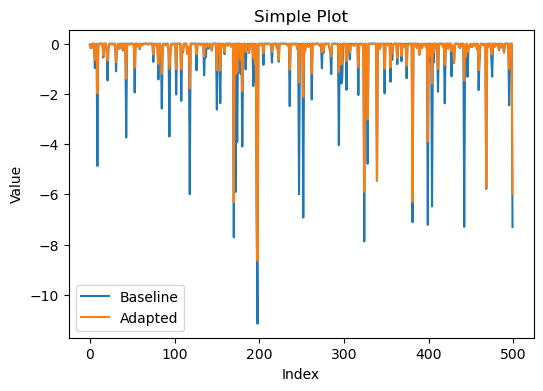

In [17]:
# Plot
plt.figure(figsize=(6,4))
plt.plot(baseline_results_df['gdp_avg'], label='Baseline')
plt.plot(adapted_results_df['gdp_avg'], label='Adapted')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Simple Plot")
plt.show()

In [35]:
aep = 0.001
gdp_aep_loss = adapted_results_df["gdp_avg"].quantile(aep)
print(gdp_aep_loss)

-8.232439403740104


In [18]:
baseline_results_df.to_csv('baseline_GDP.csv')
adapted_results_df.to_csv('adapted_GDP.csv')

### SCRATCH AREA

In [57]:
# Run DIGNAD (disaster)
tradable_impact = 0.1
nontradable_impact = 0.1
reconstruction_efficiency = 0
public_debt_premium = 0
public_impact = 0.1
private_impact = 0.1
share_tradable = 0.5
# Run function
gdp_impact, years = run_DIGNAD(sim_start_year, nat_disaster_year, recovery_period, tradable_impact, nontradable_impact, reconstruction_efficiency,
                                public_debt_premium, public_impact, private_impact, share_tradable)